# Movement prediction based on shoe insert pressure sensors

In [1]:
import numpy as np
import pandas as pd
import os
import re
from io import StringIO
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## Preparing Data
### Loading data for each subject to one text file

In [2]:
folder_names = ['data_summaries', 'validation_data_summaries']
for folder_name in folder_names:

    # make folder if it doesnt exist
    try:
        os.mkdir(folder_name)
        print("Directory" , folder_name ,  "created ") 
    except FileExistsError:
        print("Directory" , folder_name ,  "already exists")

    if folder_name == 'data_summaries':
        data_folder_name = 'data'
    if folder_name == 'validation_data_summaries':
        data_folder_name = 'validation_data'
    
    #join text files from each foder
    for folder in os.listdir(data_folder_name):
        with open(os.path.join(folder_name, 'summary_{}.txt'.format(str(folder))), "w") as outfile:
            for textfile in os.listdir(os.path.join(data_folder_name, folder)):
                contents = open( os.path.join(data_folder_name, folder, textfile) ).read()
                outfile.write(contents)

Directory data_summaries already exists
Directory validation_data_summaries already exists


In [3]:
file_list = os.listdir('data_summaries')
validation_file_list = os.listdir('validation_data_summaries')

In [4]:
def listToString(s):  
    str1 = '' 
    for ele in s:  
        str1 += ele
    return str1

### Loading all data into *df_val* and *df* as validation and train data

TYPE_ID:  
1. krok do przodu  
2. zatrzymanie  
3. chodzenie  
4. wchodzenie po rampie  
5. schodzenie z rampy  
6. wchodzenie po schodach  
7. schodzenie po schodach  
8. stanie na prawej nodze  
9. stanie na lewej nodze

In [5]:
data_rows = []
for text_file in file_list:
    subject_num = int(re.sub("[^0-9]", "", text_file))
    with open (os.path.join('data_summaries', text_file), 'r') as text_file:
        string = text_file.readlines()
        for line in tqdm(string):
            line_string = listToString( line[:-1] + '\t{}'.format(subject_num) + '\n')
            if len([s for s in line_string if '\t' in s]) == 14:
                data_rows.append(line_string)

columns = ['C_{}'.format(x) for x in range(12)] + ['TYPE_ID', 'MEASUREMENT_NO', 'SUB_NO']
print('Making string...')
data_string = ''.join(data_rows)
print('Making string object...')
string_object = StringIO(data_string)
print('Making data frame...')
df = pd.read_csv(string_object, sep='\t', header=None, usecols=range(15))
df.columns = columns
where_numeric = df.applymap(np.isreal).all(1)
df = df[where_numeric]

data_rows = []
for text_file in validation_file_list:
    subject_num = int(re.sub("[^0-9]", "", text_file))
    with open (os.path.join('validation_data_summaries', text_file), 'r') as text_file:
        string = text_file.readlines()
        for line in tqdm(string):
            line_string = listToString( line[:-1] + '\t{}'.format(subject_num) + '\n')
            if len([s for s in line_string if '\t' in s]) == 14:
                data_rows.append(line_string)

columns = ['C_{}'.format(x) for x in range(12)] + ['TYPE_ID', 'MEASUREMENT_NO', 'SUB_NO']
print('Making string...')
data_string = ''.join(data_rows)
print('Making string object...')
string_object = StringIO(data_string)
print('Making data frame...')
df_val = pd.read_csv(string_object, sep='\t', header=None, usecols=range(15))
df_val.columns = columns
where_numeric = df_val.applymap(np.isreal).all(1)
df_val = df_val[where_numeric]

100%|██████████| 95187/95187 [00:00<00:00, 101615.47it/s]
Making string...
Making string object...
Making data frame...
100%|██████████| 115307/115307 [00:01<00:00, 96590.16it/s]
Making string...
Making string object...
Making data frame...


### normalizing data from 1 to 0

In [6]:
dataf = ((df-df.min())/(df.max()-df.min()))
dataf_val = ((df_val-df.min())/(df.max()-df.min()))
dataf[['TYPE_ID', 'MEASUREMENT_NO', 'SUB_NO']] = df[['TYPE_ID', 'MEASUREMENT_NO', 'SUB_NO']]
dataf_val[['TYPE_ID', 'MEASUREMENT_NO', 'SUB_NO']] = df_val[['TYPE_ID', 'MEASUREMENT_NO', 'SUB_NO']]

## Exploration
### Pairplot of sample of 1000 from TYPE_ID == 1



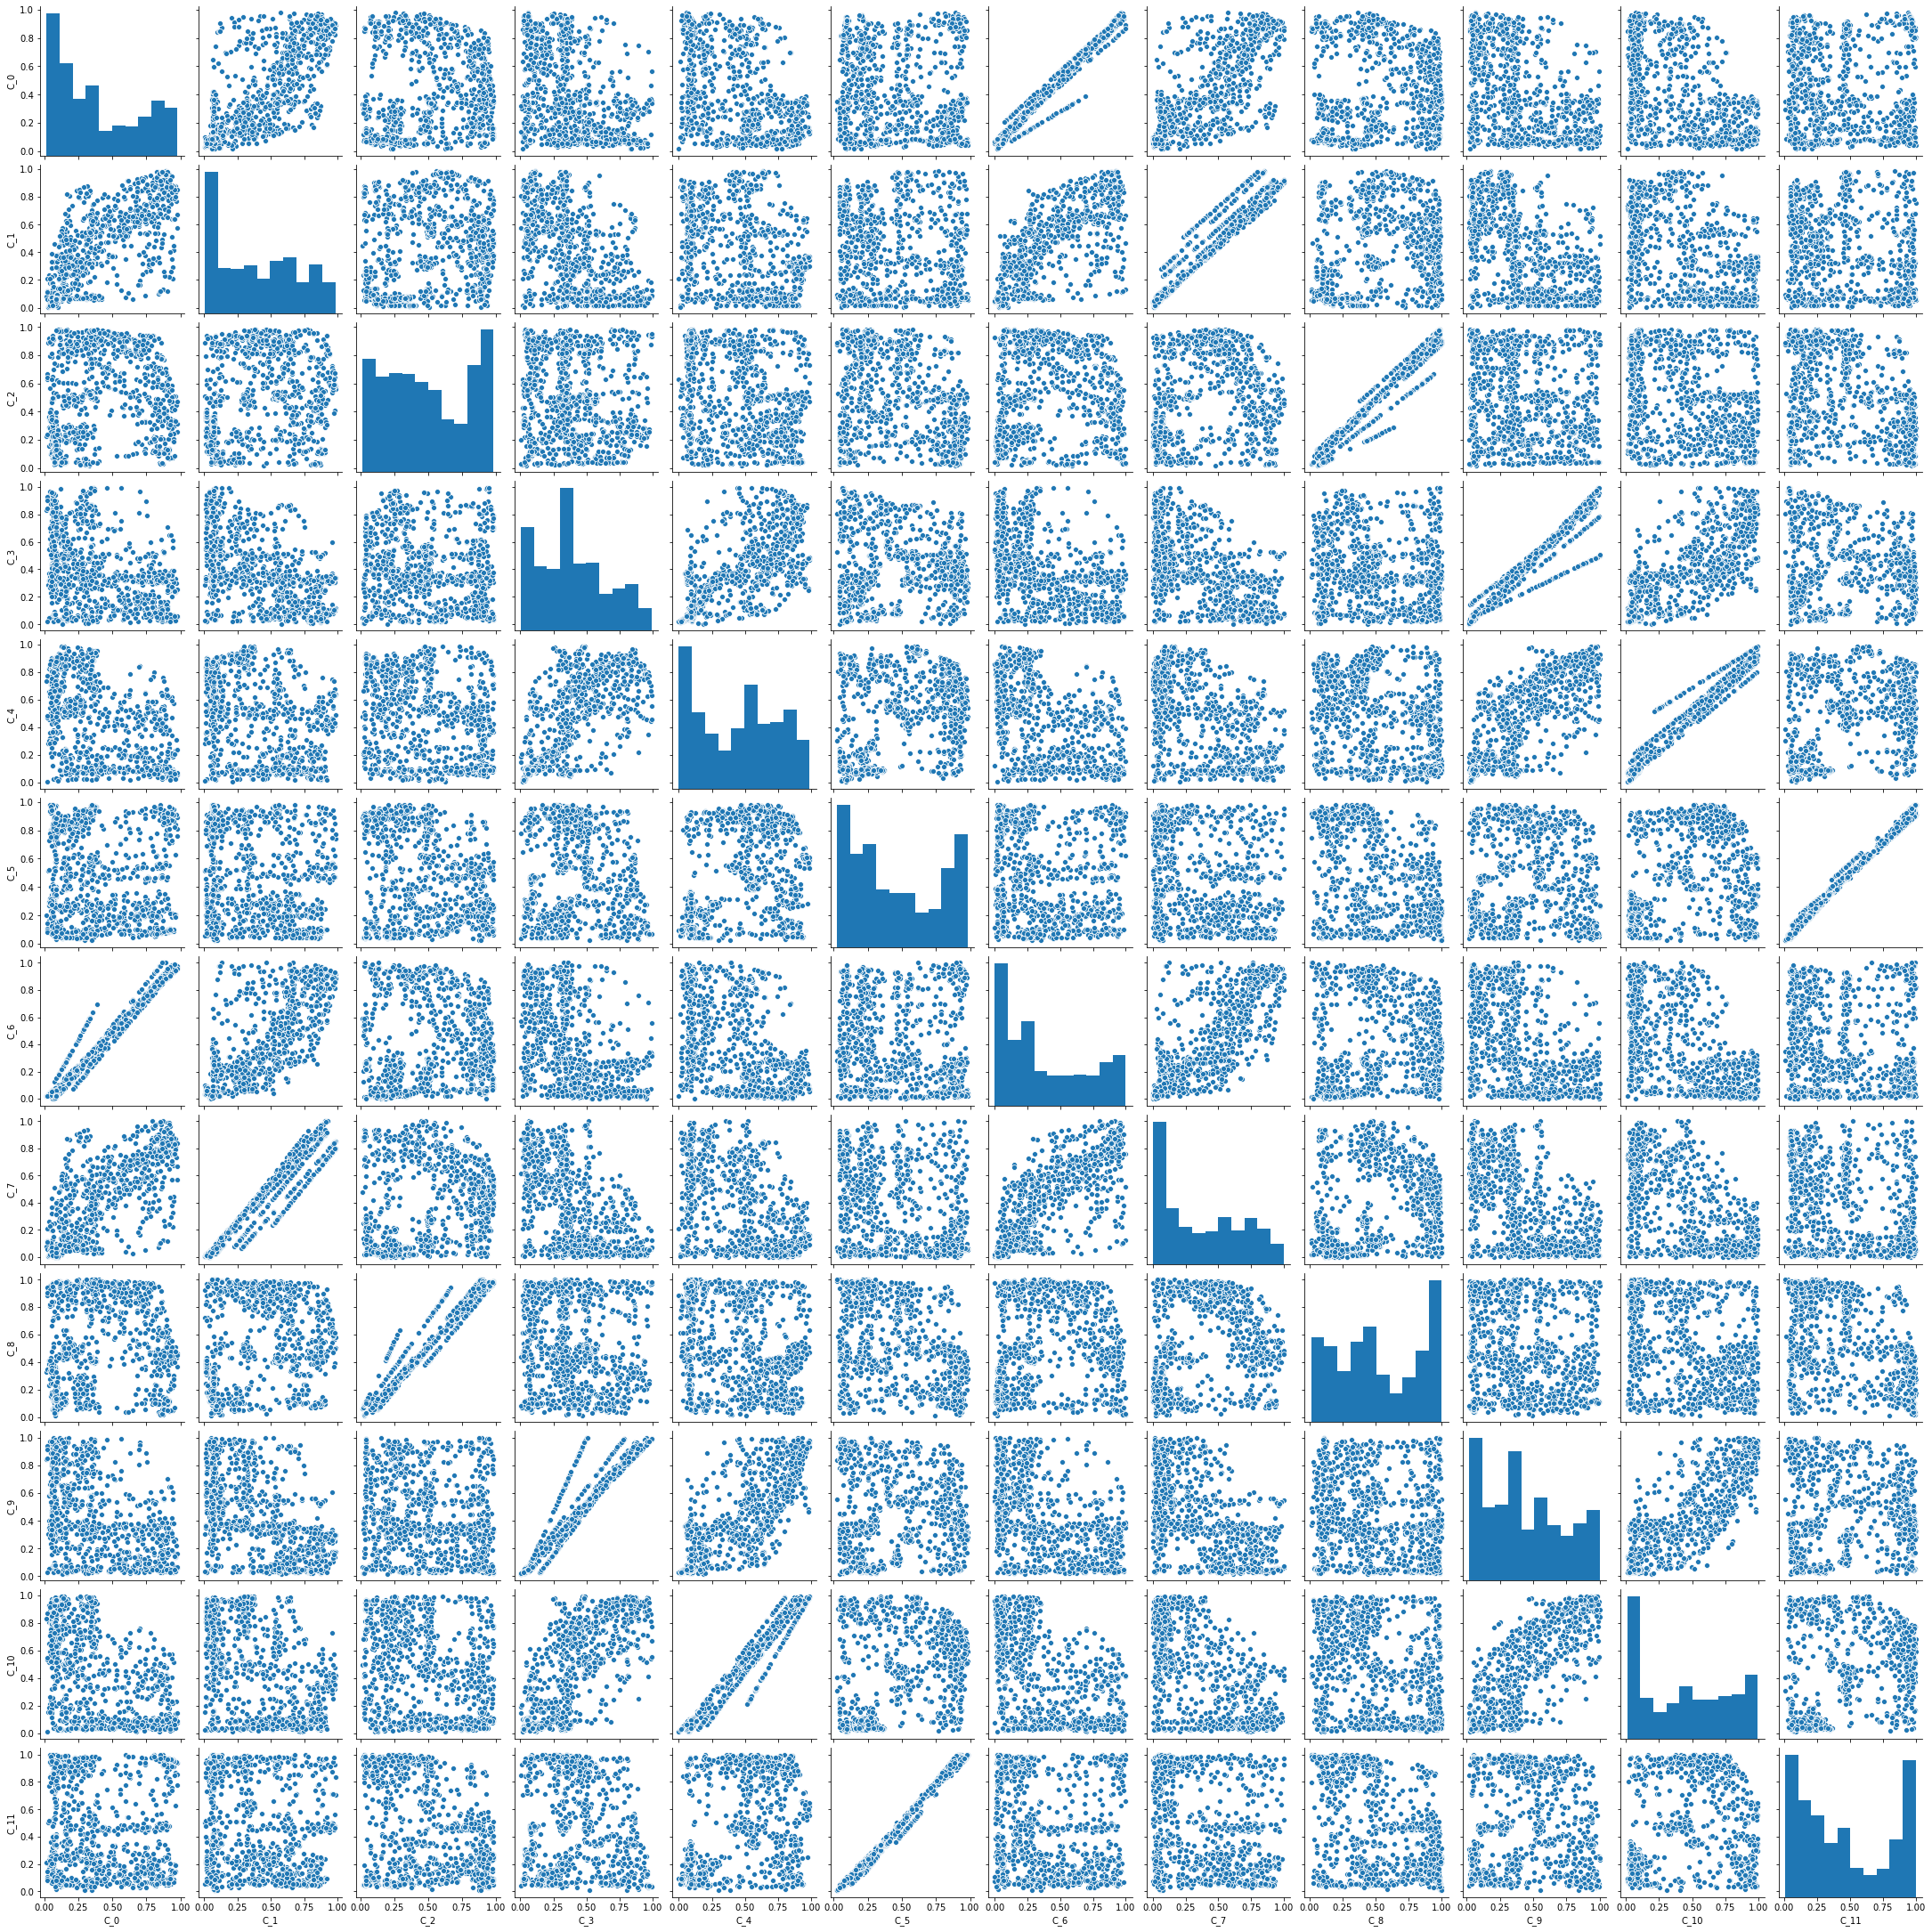

<Figure size 2160x2160 with 0 Axes>

In [7]:
from IPython.display import Image
sns_plot = sns.pairplot(dataf[dataf['TYPE_ID']==3].iloc[:, :12].sample(1000))
sns_plot.savefig("pairplot.png")
plt.clf()
Image(filename='pairplot.png')

### Sensor $C_n$ and $C_{n+6}$ are very linearly corelated no matter the movement, they could be in the similar location

<AxesSubplot:xlabel='C_2', ylabel='C_8'>

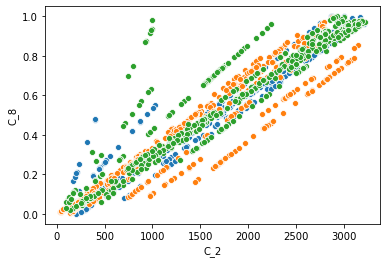

In [8]:
sample_size = 500
sns.scatterplot(df['C_0'], df['C_6'].sample(sample_size))
sns.scatterplot(df['C_1'], df['C_7'].sample(sample_size))
sns.scatterplot(df['C_2'], df['C_8'].sample(sample_size))

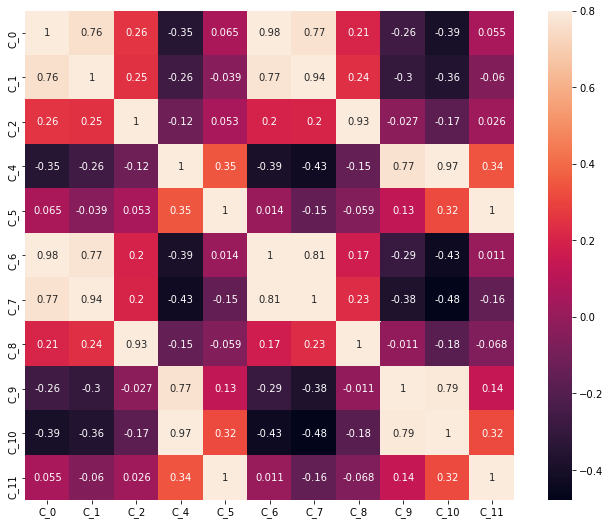

In [9]:
corrmat = dataf.iloc[:, :12].corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.8, square=True, annot=True);

## Preparing data for network
### Nesting DataFrames

In [10]:
def make_nested(dataframe):
    train_data = pd.DataFrame()
    for sub in tqdm(dataframe['SUB_NO'].unique()):
        for measurement in dataframe['MEASUREMENT_NO'].unique():
            for type_id in dataframe['TYPE_ID'].unique():
                dfslice = dataframe[ (dataframe['SUB_NO']==int(sub)) & (dataframe['MEASUREMENT_NO']==int(measurement)) & (dataframe['TYPE_ID']==int(type_id))].iloc[:, :12]
                if dfslice.shape[0]!=0:
                    train_data = train_data.append(pd.DataFrame(
                        {'values': [dfslice],
                        'TYPE_ID': [type_id]}
                    ))
    return train_data
train_data = make_nested(dataf)
val_data = make_nested(dataf_val)

100%|██████████| 11/11 [00:09<00:00,  1.17it/s]


### Count of TYPES in train and validation data

In [11]:
train_data['TYPE_ID'].value_counts()

3    114
2    113
1    103
8     97
7     94
9     90
4     87
6     82
5     80
Name: TYPE_ID, dtype: int64

In [12]:
val_data['TYPE_ID'].value_counts()

1    101
3    100
7     98
6     98
4     98
5     96
8     17
2     12
9     10
Name: TYPE_ID, dtype: int64

### fraction of data where dataframe with values are bigger than 500 (86%)

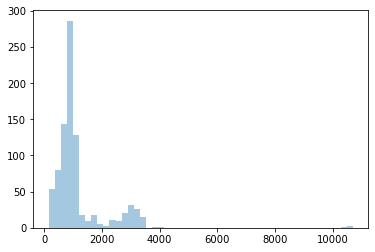

In [13]:
time_list = np.array([row.shape[0] for row in train_data.iloc[:, 0]])
sns.distplot(time_list, kde=False, norm_hist=False);

In [52]:
#for dataframe with dataframe in column 0 and int value in column 1
def cut_to_windows(nested_df, window_size):    
    boolean_mask = [row.shape[0]>window_size for row in nested_df.iloc[:, 0]]
    time_list = np.array([row.shape[0] for row in nested_df.iloc[:, 0]])
    print('{:.4}% of data was cut off'.format((len(time_list[boolean_mask])/len(time_list))*100))

    list_of_trimmed_dataframes = []
    list_of_trimmed_IDs = []
    nested_df = nested_df[boolean_mask]    
    for dataframe, Id in zip(nested_df.iloc[:, 0], nested_df.iloc[:, 1]):
        timesteps = dataframe.shape[0]
        for step in range(timesteps//window_size):
            list_of_trimmed_IDs.append(Id)
            list_of_trimmed_dataframes.append(dataframe.iloc[step*window_size:(step+1)*window_size, :])

    return pd.DataFrame({'DFs':list_of_trimmed_dataframes, 'TYPE_ID':list_of_trimmed_IDs})

In [54]:
windows_size = 512
print("train data: ")
train_data_cut = cut_to_windows(train_data, windows_size)
print("\nvalidation data: ")
val_data_cut = cut_to_windows(val_data, windows_size)

train data: 
86.05% of data was cut off

validation data: 
64.13% of data was cut off


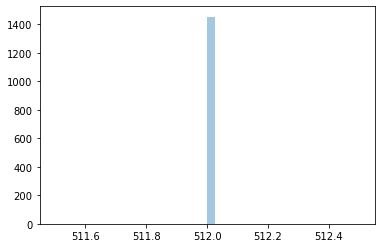

In [45]:
time_list = np.array([row.shape[0] for row in train_data_cut.iloc[:, 0]])
sns.distplot(time_list, kde=False, norm_hist=False);

## Some 1D Convolution Neural Network

In [62]:
import tensorflow as tf
#this base model is one branch of the main model
#it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenation
def get_base_model(input_shape, f_dim):
    #the input is a time series of length n and width 19
    input_ = tf.keras.layers.Input(shape=(input_shape, 12))
    nb_filters = 10
    #1-D convolution and global max-pooling
    conv = tf.keras.layers.Conv1D(nb_filters, f_dim, padding="same", activation="tanh")(input_)
    processed = tf.keras.layers.GlobalMaxPooling1D()(conv)
    #dense layer with dropout regularization
    compressed = tf.keras.layers.Dense(256, activation="tanh")(processed)
    compressed = tf.keras.layers.Dropout(0.3)(compressed)
    model = tf.keras.Model(inputs=input_, outputs=compressed)
    return model

In [63]:
get_base_model(512, 12).summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 12)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 512, 10)           1450      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2816      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
Total params: 4,266
Trainable params: 4,266
Non-trainable params: 0
_________________________________________________________________


In [66]:
#this is the main model
#it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an output
def main_model(inputs_lens = [128, 256, 512], fsizes = [8,16,24]):
    #the inputs to the branches are the original time series, and its down-sampled versions
    input_smallseq = tf.keras.layers.Input(shape=(inputs_lens[0], 12))
    input_medseq = tf.keras.layers.Input(shape=(inputs_lens[1] , 12))
    input_origseq = tf.keras.layers.Input(shape=(inputs_lens[2], 12))
    #the more down-sampled the time series, the shorter the corresponding filter
    base_net_small = get_base_model(inputs_lens[0], fsizes[0])
    base_net_med = get_base_model(inputs_lens[1], fsizes[1])
    base_net_original = get_base_model(inputs_lens[2], fsizes[2])
    embedding_small = base_net_small(input_smallseq)
    embedding_med = base_net_med(input_medseq)
    embedding_original = base_net_original(input_origseq)
    #concatenate all the outputs
    merged = tf.keras.layers.Concatenate()([embedding_small, embedding_med, embedding_original])
    out = tf.keras.layers.Dense(1, activation='sigmoid')(merged)
    model = tf.keras.Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
    return model

In [67]:
model = main_model()

In [68]:
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 12)]    0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 256, 12)]    0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 512, 12)]    0                                            
__________________________________________________________________________________________________
functional_11 (Functional)      (None, 256)          3786        input_10[0][0]                   
______________________________________________________________________________________

In [70]:
def generator(data):
    while True:
        for dataframe, Id in zip(data.iloc[:, 0], data.iloc[:, 1]):
            yield(dataframe, Id)

In [ ]:
batch_size = 8
data_size = 12009
val_data_size = 3547
num_epochs = 24
results = model.fit(
    trainGenerator(case_numbers_train, batch_size),
    steps_per_epoch = data_size // batch_size,
    epochs = num_epochs,
    callbacks = callbacks,
    verbose = 1,
    validation_data = validationGenerator(case_numbers_val, batch_size),
    validation_steps = val_data_size // batch_size
    )